# TODO Needs Comments


In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import seaborn as sns
from sklearn import model_selection


mpl.rcParams['figure.dpi'] = 300


# Configuring paths and loading raw data
home_directory = r"D:\OneDrive\Documents\PhD Jesse\Embryonic_organoid_prediction\Processing dataset for Paper\TLS_2D_morphostate_investigation/"
table_location = home_directory + "tabular_data"

translation_frame = pd.read_csv("translation_dataframe_timepoints.csv")
name_mapping = {key:new_key for key,new_key in zip(translation_frame["original_names"],translation_frame["plot_names"])}

data = pd.read_csv(f"{table_location}/All_Samples_Feature_Space_All_Features_48h,72h,96h_Normalised_per_Timepoint.csv")

# Adding Annotations to Data
annotations = table_location + "/annotations_with_indices.csv"
annotation_df = pd.read_csv(annotations)
mapping = {"Real_Run":"RR", "Trial_Run":"TR"}
annotation_df["Run"] = [mapping[value] for value in annotation_df["Run"].to_numpy()]
no_na_annot = annotation_df[annotation_df["Morph_Class"]!="NA_NA"]
data_annotated = data.set_index(["Run","Plate","ID"]).merge(no_na_annot,on=["Run","Plate","ID"])

# Filtering to relevant dataset
dat_morph = data_annotated[data_annotated["Morph"] != "unclassified"]
dat_morph = dat_morph[dat_morph['048h_raw_BF_AreaShape_area'].notna()].dropna(axis=1).dropna()
dat_morph = dat_morph.drop([key for key in dat_morph.keys() if any([term in key for term in ["Location","orientation","_X","_Y","UMAP","PC","096"]])],axis=1) #,
counts = dat_morph.groupby("Morph")["Run"].count()
print(counts)


dat_morph

Morph
bad     183
good    128
Name: Run, dtype: int64


,Run,Plate,ID,048h_raw_BF_AreaShape_area,048h_raw_BF_AreaShape_aspect_ratio,048h_raw_BF_AreaShape_axis_major_length,048h_raw_BF_AreaShape_axis_minor_length,048h_raw_BF_AreaShape_eccentricity,048h_raw_BF_AreaShape_feret_diameter_max,048h_raw_BF_AreaShape_perimeter,...,072h_str_BF_AreaShape_moments_hu_3,072h_str_BF_AreaShape_moments_hu_4,072h_str_BF_AreaShape_moments_hu_5,072h_str_BF_AreaShape_moments_hu_6,072h_str_BF_AreaShape_perimeter,072h_str_CH_AreaShape_Bra_MajorAxis_Polarisation,072h_str_CH_AreaShape_Bra_MinorAxis_Polarisation,Axes,Morph,Morph_Class
0,RR,1,A1,0.754091,-0.889636,0.132588,1.204628,-1.000051,0.007074,0.615519,...,-0.090511,0.012002,0.035048,-0.014919,1.586625,2.227379,-0.598532,single,good,single_good
1,RR,1,A2,-0.783470,-1.252670,-1.238409,0.003129,-1.752936,-1.131530,-0.724230,...,0.041954,0.047191,0.018409,0.012963,-1.014957,2.069796,-1.182707,single,bad,single_bad
2,RR,1,A3,1.636441,-0.184192,1.186196,1.565451,-0.008740,1.127225,1.795347,...,0.187342,0.029087,0.248552,-0.020550,1.718106,-0.235515,-0.604653,single,bad,single_bad
3,RR,1,A4,-0.525754,-0.513477,-0.672134,-0.202863,-0.422446,-0.849309,-0.402853,...,-0.251460,0.005352,0.000446,-0.057463,-0.118754,-0.010792,0.747780,single,good,single_good
4,RR,1,A5,0.537872,-0.248943,0.294790,0.612413,-0.084969,0.059492,0.498737,...,2.862632,-0.652737,-0.851691,2.754113,0.576026,0.491296,-1.096685,single,bad,single_bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,TR,2,H4,-1.801231,0.189615,-1.378837,-1.801012,0.392510,-1.263560,-1.668959,...,-0.287971,0.006413,0.010646,-0.055293,-1.738433,-0.546494,-0.447613,single,good,single_good
430,TR,2,H5,-1.805599,0.135760,-1.400417,-1.768377,0.338334,-1.393948,-2.002972,...,-0.293490,0.006283,0.004926,-0.055490,-1.465463,0.565962,4.216196,single,bad,single_bad
434,TR,2,H9,-0.925432,1.281638,-0.116354,-1.536867,1.304509,-0.330223,-1.009869,...,-0.314168,0.006469,0.009380,-0.055223,-1.811582,1.109458,-1.050026,single,good,single_good
436,TR,2,H11,-2.408392,-0.915375,-2.411391,-1.803167,-1.045366,-2.414625,-2.306480,...,-0.317047,0.006477,0.009617,-0.055214,-2.184405,-0.131288,1.087728,single,good,single_good


# First Lets See How Much Normal PLSR Differs from Randomised PLSR

In [14]:
gt_keys = ["Run","Plate","ID","Axes","Morph","Morph_Class"]
X = dat_morph.drop(gt_keys,axis=1)
Y = pd.get_dummies(dat_morph["Morph"])["good"]
Y

0       True
1      False
2      False
3       True
4      False
       ...  
429     True
430    False
434     True
436     True
437     True
Name: good, Length: 311, dtype: bool

In [15]:
# fit the regular pls regression
my_plsr = PLSRegression(n_components=2, scale=False)
my_plsr.fit(StandardScaler().fit_transform(X), Y)

# extract scores (one score per individual per component)
scores_df = pd.DataFrame(my_plsr.x_scores_)

# standardize scores between -1 and 1 so they fit on the plot
std_scores_dim1 = 2 * ( (scores_df[0] - min(scores_df[0])) / (max(scores_df[0]) - min(scores_df[0])) ) -1
std_scores_dim2 = 2 * ( (scores_df[1] - min(scores_df[1])) / (max(scores_df[1]) - min(scores_df[1])) ) -1


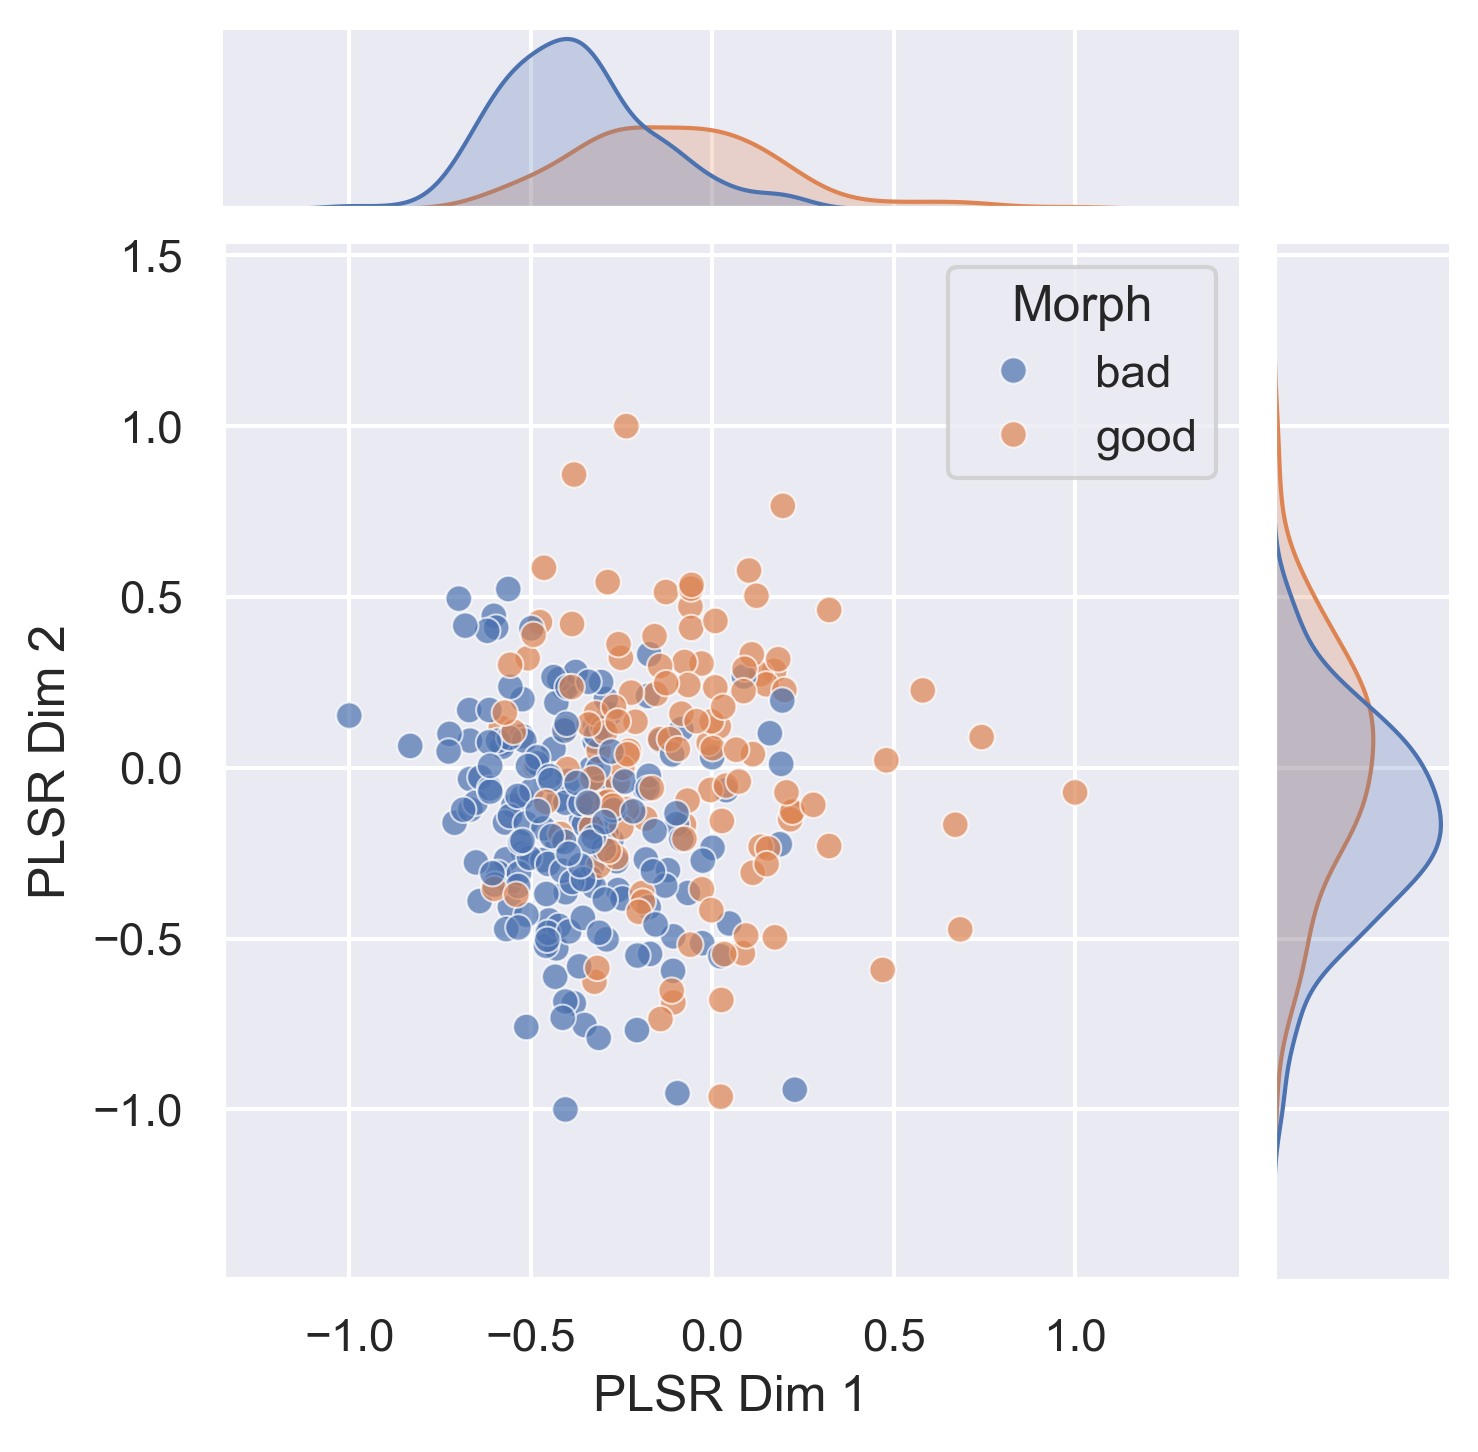

In [16]:
sns.set()

df_components = pd.DataFrame(
    {
        "Morph":dat_morph["Morph"].to_numpy(),
        "good":Y.to_numpy().astype(bool),
        "PLSR Dim 1":std_scores_dim1,
        "PLSR Dim 2":std_scores_dim2,
    }
)

sns.jointplot(df_components,x="PLSR Dim 1",y="PLSR Dim 2",hue="Morph", **{"alpha":0.7,"s":40},height=5,hue_order=["bad","good"])
plt.show()

In [17]:
# randomised labels
random_X = np.array(X)[np.random.choice(len(X), size = len(X),replace = False)]

# fit randomised plsr
my_plsr_random = PLSRegression(n_components=2, scale=False)
my_plsr_random.fit(StandardScaler().fit_transform(random_X), Y)

# extract scores (one score per individual per component)
scores_df_random = pd.DataFrame(my_plsr_random.x_scores_)

# standardize scores between -1 and 1 so they fit on the plot
std_random_scores_dim1 = 2 * ( (scores_df_random[0] - min(scores_df_random[0])) / (max(scores_df_random[0]) - min(scores_df_random[0])) ) -1
std_random_scores_dim2 = 2 * ( (scores_df_random[1] - min(scores_df_random[1])) / (max(scores_df_random[1]) - min(scores_df_random[1])) ) -1

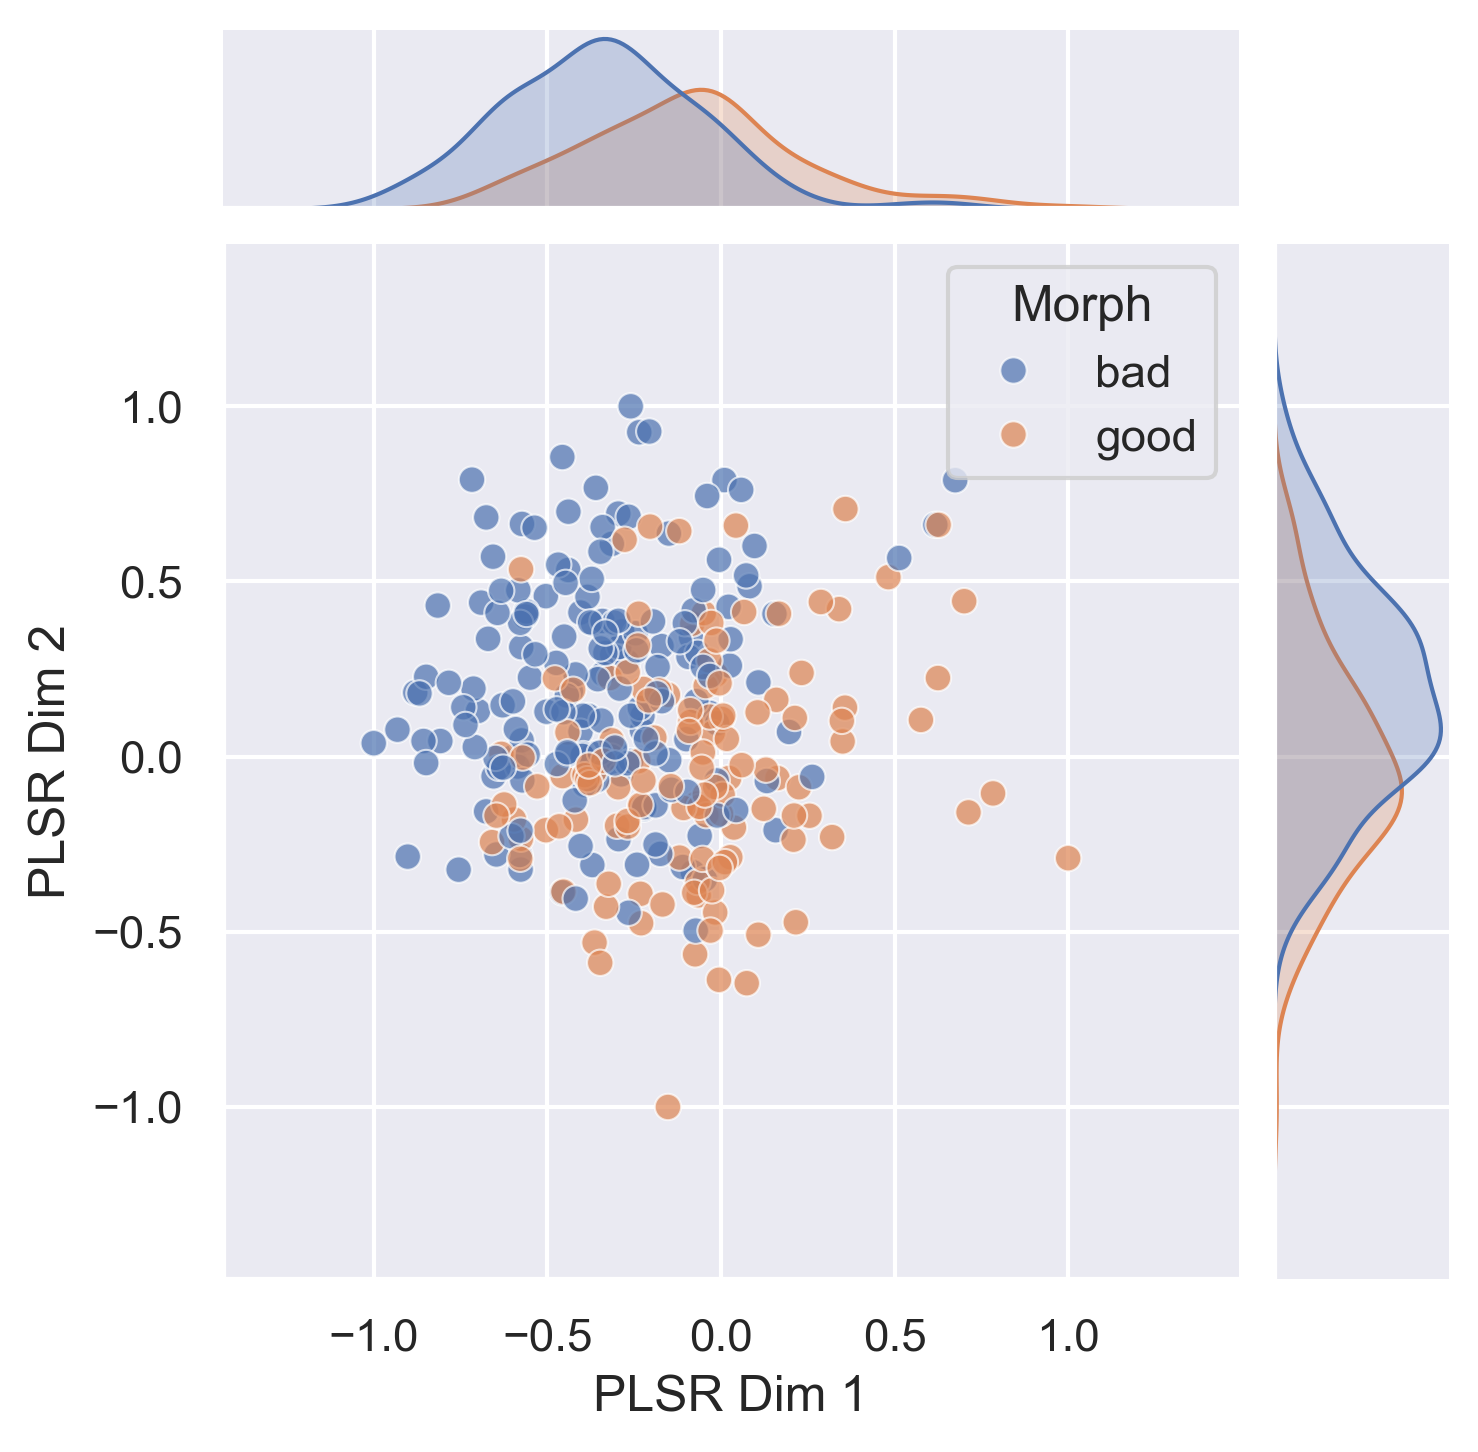

In [18]:
df_components = pd.DataFrame(
    {
        "Morph":dat_morph["Morph"].to_numpy(),
        "good":Y.to_numpy().astype(bool),
        "PLSR Dim 1":std_random_scores_dim1,
        "PLSR Dim 2":std_random_scores_dim2,
    }
)

sns.jointplot(df_components,x="PLSR Dim 1",y="PLSR Dim 2",hue="Morph", **{"alpha":0.7,"s":40},height=5,hue_order=["bad","good"])
#plt.savefig(f"{out_fig_2}/PLSR Morph components.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [19]:
df_components[df_components["good"] == True]["PLSR Dim 1"].mean() > df_components[df_components["good"] == False]["PLSR Dim 1"].mean()

True

In [20]:
# Repeating PLSR multiple times while just randomising the order of samples

np.random.seed(42)

n_to_leave_out = int(0.2*len(X))
print(n_to_leave_out)

normal_plsr_loadings = []
normal_plsr_scores = []
normal_indices = []
normal_labels = []

for i in range(100):
    random_indices = np.random.choice(len(X),size = len(X)-n_to_leave_out, replace=False)
    random_indices_2 = np.random.choice(len(X),size = len(X)-n_to_leave_out, replace=False)
    
    normal_indices.append(random_indices)
    
    my_plsr = PLSRegression(n_components=2, scale=False)
    my_plsr.fit(StandardScaler().fit_transform(np.array(X)[random_indices]), np.array(Y)[random_indices])
    
    normal_labels.append(np.array(Y)[random_indices])
    # extract scores (one score per individual per component)
    scores_df = pd.DataFrame(my_plsr.x_scores_,columns=["PLSR_Dim_1","PLSR_Dim_2"])
    scores_df["original_indices"] = random_indices
    scores_df["good"] = np.array(Y)[random_indices]
    normal_plsr_scores.append(scores_df.set_index("original_indices"))
    
    # extract_loadings
    loadings_df = pd.DataFrame(my_plsr.x_loadings_,index=X.columns,columns=["PLSR Dim 1","PLSR Dim 2"])
    normal_plsr_loadings.append(loadings_df)

62


In [21]:
pd.concat([df[["PLSR_Dim_1","good"]] for df in normal_plsr_scores],axis=1)

,PLSR_Dim_1,good,PLSR_Dim_1,good,PLSR_Dim_1,good,PLSR_Dim_1,good,PLSR_Dim_1,good,...,PLSR_Dim_1,good,PLSR_Dim_1,good,PLSR_Dim_1,good,PLSR_Dim_1,good,PLSR_Dim_1,good
original_indices,,,,,,,,,,,,,,,,,,,,,
290,6.572364,True,10.275233,True,9.231320,True,NaN,NaN,9.564423,True,...,NaN,NaN,8.264750,True,NaN,NaN,6.726378,True,7.398639,True
9,6.064619,True,NaN,NaN,5.305184,True,NaN,NaN,NaN,NaN,...,5.349180,True,5.958905,True,6.124632,True,6.210091,True,5.394792,True
57,3.030452,True,NaN,NaN,3.019914,True,3.374261,True,2.691446,True,...,2.825692,True,2.633382,True,NaN,NaN,NaN,NaN,3.335585,True
60,-3.206034,False,-2.884008,False,-2.867415,False,-3.140930,False,-3.377362,False,...,-3.057049,False,NaN,NaN,-3.163017,False,-3.722303,False,-3.857635,False
25,-2.557404,True,-3.162895,True,-2.352115,True,-2.343271,True,-2.799143,True,...,NaN,NaN,NaN,NaN,-1.922270,True,-2.305994,True,-1.681433,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,NaN,NaN,NaN,NaN,-0.777931,False,-0.993411,False,-0.656864,False,...,-1.068804,False,-1.094845,False,NaN,NaN,-1.573086,False,-1.282663,False
241,NaN,NaN,NaN,NaN,0.745866,False,0.852423,False,1.538907,False,...,NaN,NaN,1.116089,False,0.078938,False,NaN,NaN,0.748739,False
53,NaN,NaN,NaN,NaN,-0.689737,False,-1.377440,False,-0.783766,False,...,-2.564575,False,-1.906426,False,-2.790229,False,-3.362573,False,-1.947798,False


In [22]:
# Repeating PLSR multiple times while just randomising the labels

np.random.seed(42)

random_plsr_loadings = []
random_plsr_scores = []
indices_random_1 = []
indices_random_2 = []
for i in range(100):
    random_indices = np.random.choice(len(X),size = len(X)-n_to_leave_out, replace=False)
    random_indices_2 = np.random.choice(len(X),size = len(X)-n_to_leave_out, replace=False)
    
    indices_random_1.append(random_indices)
    indices_random_2.append(random_indices_2)
    
    my_plsr = PLSRegression(n_components=2, scale=False)
    my_plsr.fit(StandardScaler().fit_transform(np.array(X)[random_indices]), np.array(Y)[random_indices_2])
    
    # extract scores (one score per individual per component)
    scores_df = pd.DataFrame(my_plsr.x_scores_,columns=["PLSR_Dim_1","PLSR_Dim_2"])
    scores_df["original_indices"] = random_indices
    scores_df["randomised good"] = np.array(Y)[random_indices_2]
    random_plsr_scores.append(scores_df.set_index("original_indices"))
    
    # extract_loadings
    loadings_df = pd.DataFrame(my_plsr.x_loadings_,index=X.columns,columns=["PLSR Dim 1","PLSR Dim 2"])
    random_plsr_loadings.append(loadings_df)

In [23]:
pd.concat([df[["PLSR_Dim_1","randomised good"]] for df in random_plsr_scores],axis=1)

,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,...,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good,PLSR_Dim_1,randomised good
original_indices,,,,,,,,,,,,,,,,,,,,,
290,1.392611,True,-5.948366,False,2.848682,False,NaN,NaN,-7.551917,True,...,NaN,NaN,0.260828,False,NaN,NaN,8.588095,True,5.649911,True
9,2.819897,False,NaN,NaN,-3.487286,True,NaN,NaN,NaN,NaN,...,0.062347,False,-3.113330,True,-2.883978,False,0.240371,False,3.514742,True
57,1.217765,False,NaN,NaN,-1.520152,True,0.585723,True,-1.422187,False,...,1.879598,True,-2.153803,True,NaN,NaN,NaN,NaN,-1.456701,False
60,-0.530516,False,2.065374,False,-4.757894,True,-0.966197,False,-0.071235,True,...,-2.115696,False,NaN,NaN,0.560460,True,-0.972736,True,0.710172,True
25,1.593079,False,1.948224,False,-3.809236,True,-1.406715,False,1.861363,False,...,NaN,NaN,NaN,NaN,-1.073295,False,-2.193507,True,-1.006278,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,NaN,NaN,NaN,NaN,0.598431,False,0.869100,False,0.242021,False,...,-2.503326,True,0.647107,True,NaN,NaN,3.254451,False,1.580807,False
241,NaN,NaN,NaN,NaN,-1.705298,False,-0.289806,True,-1.205775,False,...,NaN,NaN,0.688473,True,-0.995241,False,NaN,NaN,1.586239,True
53,NaN,NaN,NaN,NaN,-1.931532,True,-0.685375,False,-4.082913,False,...,-6.394881,False,2.195985,False,6.855818,True,9.037236,False,4.614269,False


In [24]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

metrics = [davies_bouldin_score,calinski_harabasz_score,silhouette_score]

score_dataframes = []

for name,label_name,plsr_scores in zip(["Normal","Random"],["good","randomised good"],[normal_plsr_scores,random_plsr_scores]):
    
    
    separation_index = pd.DataFrame()
    separation_index["Data"] = [name for i in range(len(plsr_scores))]
    for metric in metrics:
        scores = []
        for df in plsr_scores:
            feats = df[["PLSR_Dim_1","PLSR_Dim_2"]]
            labels = df[label_name]
            score = metric(feats,labels)
            #print(score)
            scores.append(score)
        separation_index[metric.__name__] = scores
        
    score_dataframes.append(separation_index)
    
all_scores = pd.concat(score_dataframes,axis=0,ignore_index=True)
all_scores

,Data,davies_bouldin_score,calinski_harabasz_score,silhouette_score
0,Normal,1.806265,58.721223,0.178256
1,Normal,2.004599,48.137572,0.165890
2,Normal,1.841137,55.826126,0.174010
3,Normal,1.566650,74.394665,0.215448
4,Normal,1.862996,54.108337,0.179328
...,...,...,...,...
195,Random,2.564633,28.132335,0.082372
196,Random,2.156077,40.078809,0.121755
197,Random,2.531729,28.002588,0.071431
198,Random,2.406980,30.236627,0.094757


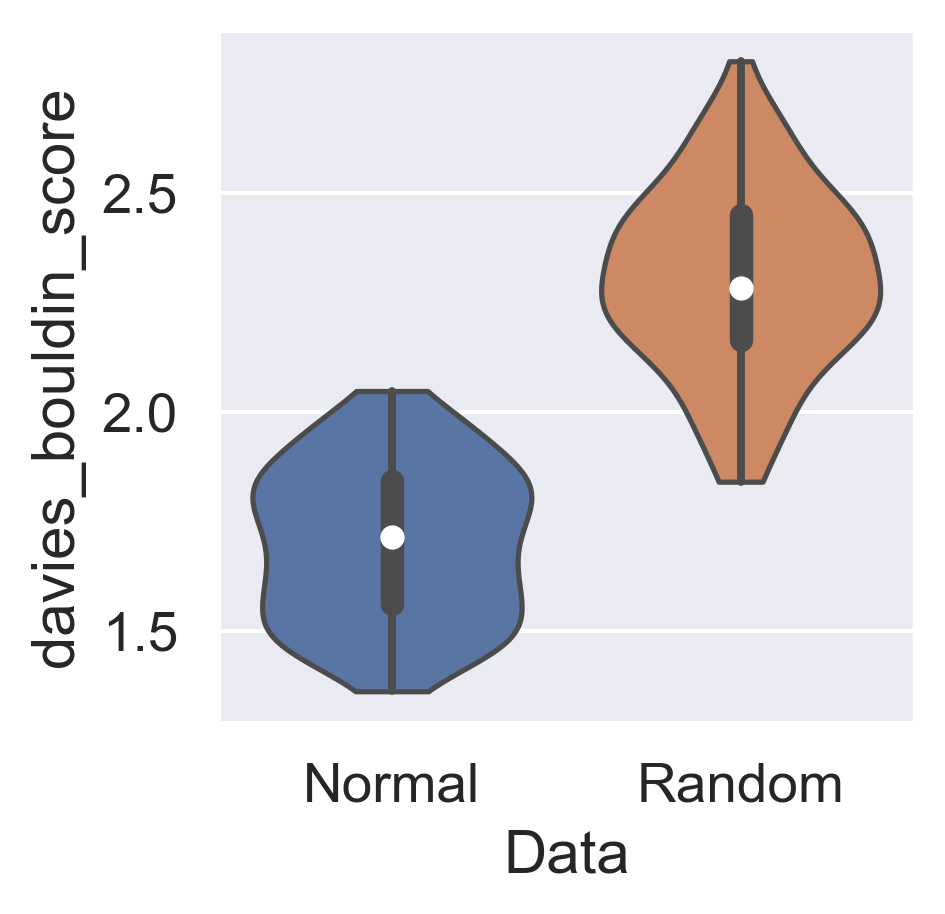

In [25]:
import os

out_revisions = r"D:\OneDrive\Documents\PhD Jesse\Embryonic_organoid_prediction\Processing dataset for Paper\TLS_2D_morphostate_investigation\Plots\Revisions"
if not os.path.isdir(out_revisions):
    os.mkdir(out_revisions)

sns.set(font_scale=1.2)
    
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.violinplot(all_scores,x="Data",y="davies_bouldin_score",ax=ax,cut=0,hue="Data",inner_kws={"marker":"o"})
plt.savefig(f"{out_revisions}/PLSR Morph early features Davies Bouldin Score 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

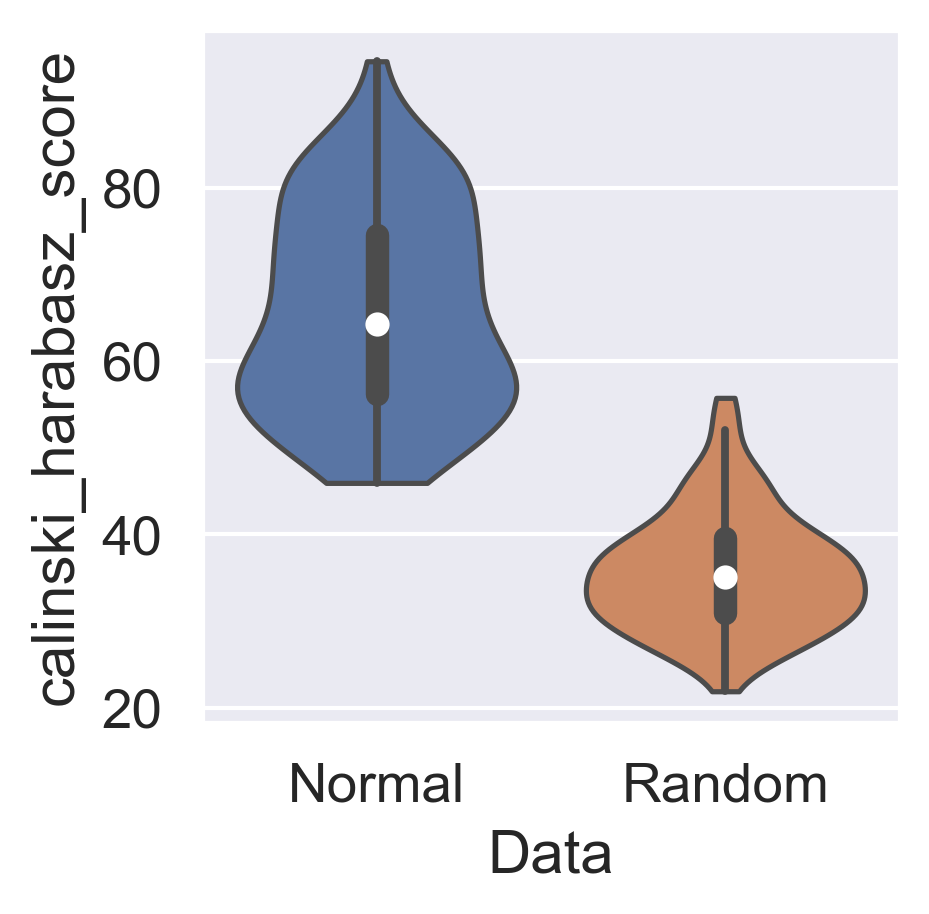

In [26]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.violinplot(all_scores,x="Data",y="calinski_harabasz_score",ax=ax,cut=0,hue="Data",inner_kws={"marker":"o"})
plt.savefig(f"{out_revisions}/PLSR Morph early features Calinski Harabasz Score 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

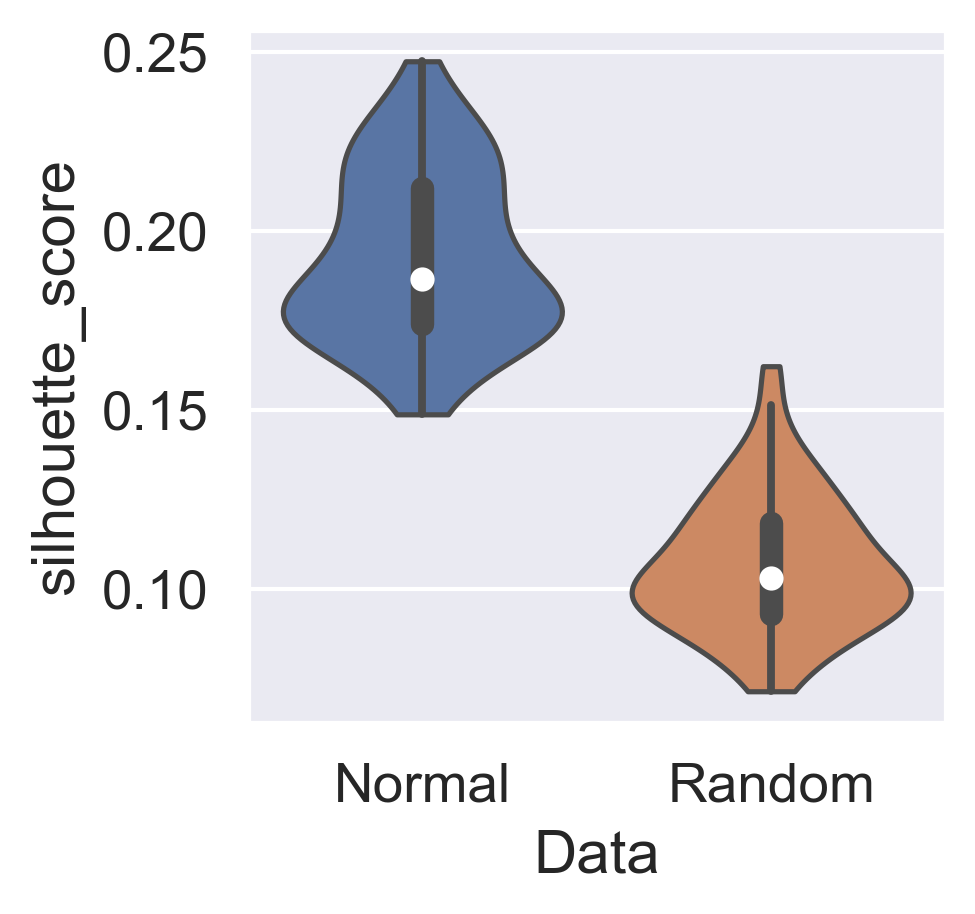

In [27]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.violinplot(all_scores,x="Data",y="silhouette_score",ax=ax,cut=0,hue="Data",inner_kws={"marker":"o"})
plt.savefig(f"{out_revisions}/PLSR Morph early features Silhouette Score 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

In [28]:
score_ranks = {metric.__name__:all_scores[metric.__name__].rank(ascending=bool(flag)).to_numpy() for metric, flag in zip(metrics, [0,1,1])}
score_ranks = pd.DataFrame(score_ranks)
score_ranks["Data"] = all_scores["Data"]
score_ranks["Avg Rank"] = np.mean(score_ranks[["davies_bouldin_score","calinski_harabasz_score","silhouette_score"]].to_numpy(),axis=1)
score_ranks

,davies_bouldin_score,calinski_harabasz_score,silhouette_score,Data,Avg Rank
0,136.0,137.0,136.0,Normal,136.333333
1,94.0,100.0,110.0,Normal,101.333333
2,125.0,124.0,125.0,Normal,124.666667
3,173.0,174.0,181.0,Normal,176.000000
4,117.0,115.0,138.0,Normal,123.333333
...,...,...,...,...,...
195,11.0,14.0,9.0,Random,11.333333
196,78.0,80.0,80.0,Random,79.333333
197,15.0,13.0,1.0,Random,9.666667
198,32.0,21.0,29.0,Random,27.333333


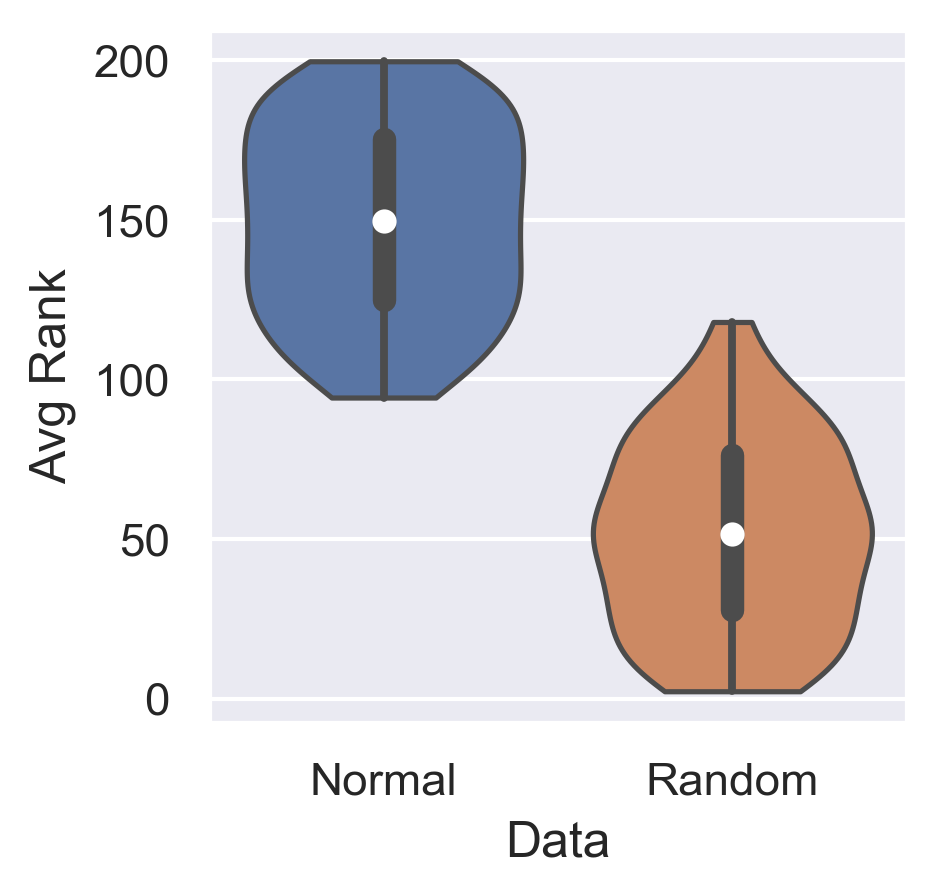

In [29]:
sns.set()

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.violinplot(score_ranks,x="Data",y="Avg Rank",ax=ax,cut=0,hue="Data",inner_kws={"marker":"o"})
#sns.stripplot(score_ranks,x="Data",y="Avg Rank",ax=ax,palette="tab10",alpha=0.7,edgecolor = "white", linewidths = 2)
plt.savefig(f"{out_revisions}/PLSR Morph early features avg separation rank 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

<Axes: xlabel='Data', ylabel='Avg Rank'>

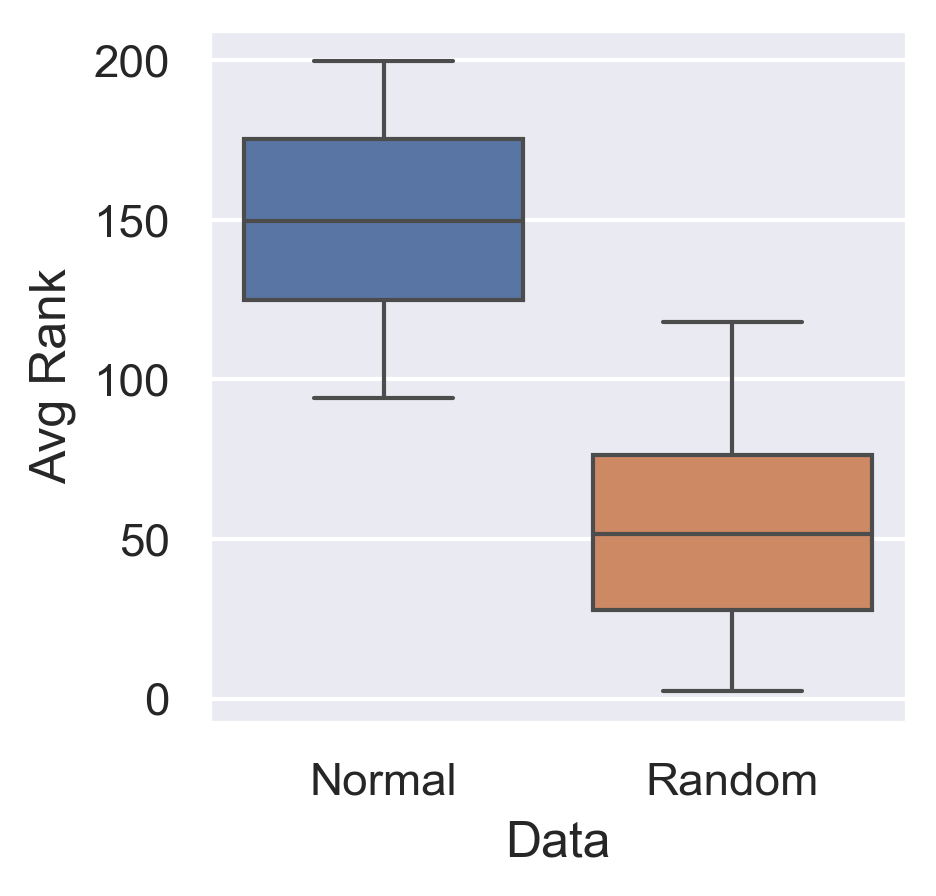

In [30]:
sns.set()

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.boxplot(score_ranks,x="Data",y="Avg Rank",ax=ax, hue="Data")
#sns.stripplot(score_ranks,x="Data",y="Avg Rank",ax=ax,palette="tab10",alpha=0.7,edgecolor = "white", linewidths = 2)
#plt.savefig(f"{out_revisions}/PLSR Morph avg separation rank 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

In [31]:
kfold_split = model_selection.StratifiedKFold(n_splits=5)
kfold_split.get_n_splits(X,Y)

5

In [32]:
from sklearn import metrics

all_confusion_matrices = []
all_test_y_pred_y = []
all_pred_y_nothresh = []
for i, (train_index, test_index) in enumerate(kfold_split.split(X,Y)):
    train_X, test_X, train_Y, test_Y = X.to_numpy()[train_index],X.to_numpy()[test_index],Y.to_numpy()[train_index],Y.to_numpy()[test_index]
    my_plsr = PLSRegression(n_components=2, scale=False)
    my_plsr.fit(np.array(train_X), np.array(train_Y))

    test_pred = (my_plsr.predict(np.array(test_X)) > 0.5)[:,0]
    matrix = metrics.confusion_matrix(test_Y,test_pred,)
    all_confusion_matrices.append(matrix)
    all_test_y_pred_y.append((test_Y,test_pred))
    all_pred_y_nothresh.append(my_plsr.predict(np.array(test_X)))

In [33]:
norm_confusion_matrices = [matrix/np.sum(matrix) for matrix in all_confusion_matrices]

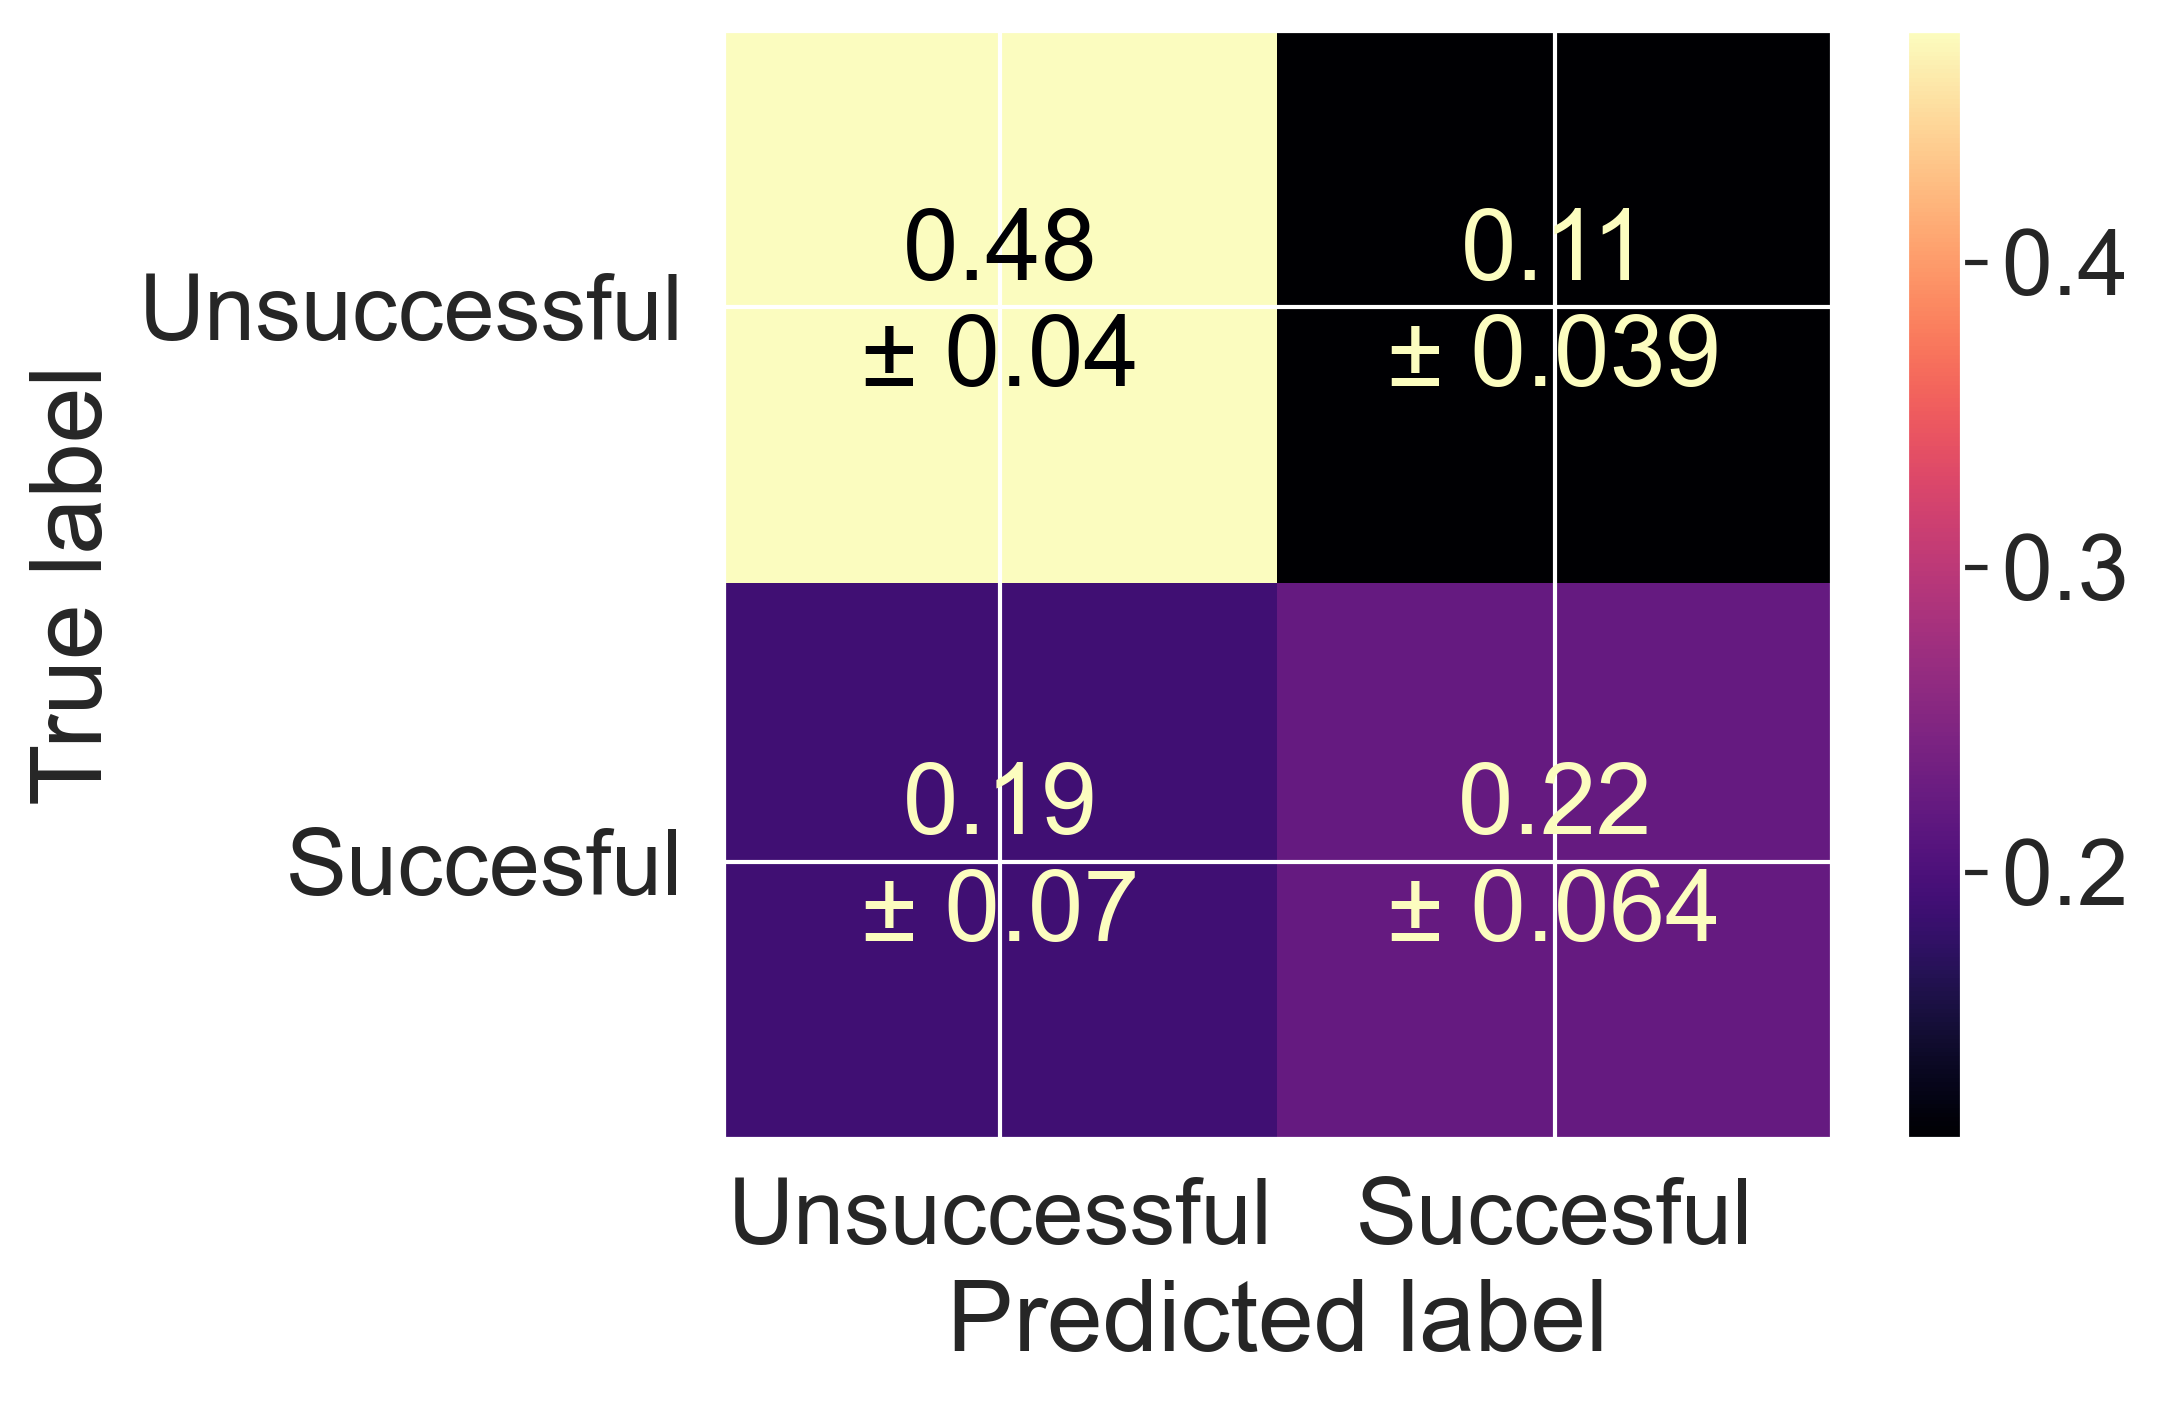

In [34]:
sns.set(font_scale = 2)
disp = metrics.ConfusionMatrixDisplay(np.mean(norm_confusion_matrices,axis=0),display_labels=["Unsuccessful","Succesful"],)
disp.plot(cmap="magma")
new_text_mat = np.zeros_like(disp.text_)

for i,(row_text, row_std) in enumerate(zip(disp.text_,np.std(norm_confusion_matrices,axis=0))):
    for j,(text_object, std_dev) in enumerate(zip(row_text,row_std)):
        new_text = text_object._text +"\n"+u"\u00B1"+" "+ str(np.round(std_dev,decimals=3))
        text_object._text = new_text
        new_text_mat[i,j] = text_object

disp.text_ = new_text_mat
disp.figure_

plt.savefig(f"{out_revisions}/PLSR Morph early features Predictions COnfusion Matrix 5 Fold Cross Validation.pdf", format="pdf", bbox_inches="tight")

In [35]:
balanced_accuracies_normal = [metrics.balanced_accuracy_score(true,pred) for true, pred in all_test_y_pred_y]
balanced_accuracies_normal

[0.6091476091476091,
 0.5897435897435898,
 0.6527777777777778,
 0.7394594594594595,
 0.7848648648648648]

In [36]:
roc_auc_normal = [metrics.roc_auc_score(true,pred) for (true,_),pred in zip(all_test_y_pred_y,all_pred_y_nothresh)]
roc_auc_normal

[0.735966735966736,
 0.6356837606837606,
 0.6463675213675213,
 0.8529729729729729,
 0.8616216216216217]

In [37]:
np.random.seed(42)

random_indices = np.random.choice(len(X),size = len(X), replace=False)

all_confusion_matrices_random = []
all_test_y_pred_y_random = []
all_pred_y_nothresh_random = []
X_np = X.to_numpy()
Y_np = Y.to_numpy()[random_indices]


for i, (train_index, test_index) in enumerate(kfold_split.split(X_np,Y_np)):
    train_X, test_X, train_Y, test_Y = X_np[train_index],X_np[test_index],Y_np[train_index],Y_np[test_index]
    my_plsr = PLSRegression(n_components=2, scale=False)
    my_plsr.fit(np.array(train_X), np.array(train_Y))

    test_pred = (my_plsr.predict(np.array(test_X)) > 0.5)[:,0]
    matrix = metrics.confusion_matrix(test_Y,test_pred,)
    all_confusion_matrices_random.append(matrix)
    all_test_y_pred_y_random.append((test_Y,test_pred))
    all_pred_y_nothresh_random.append(my_plsr.predict(np.array(test_X)))

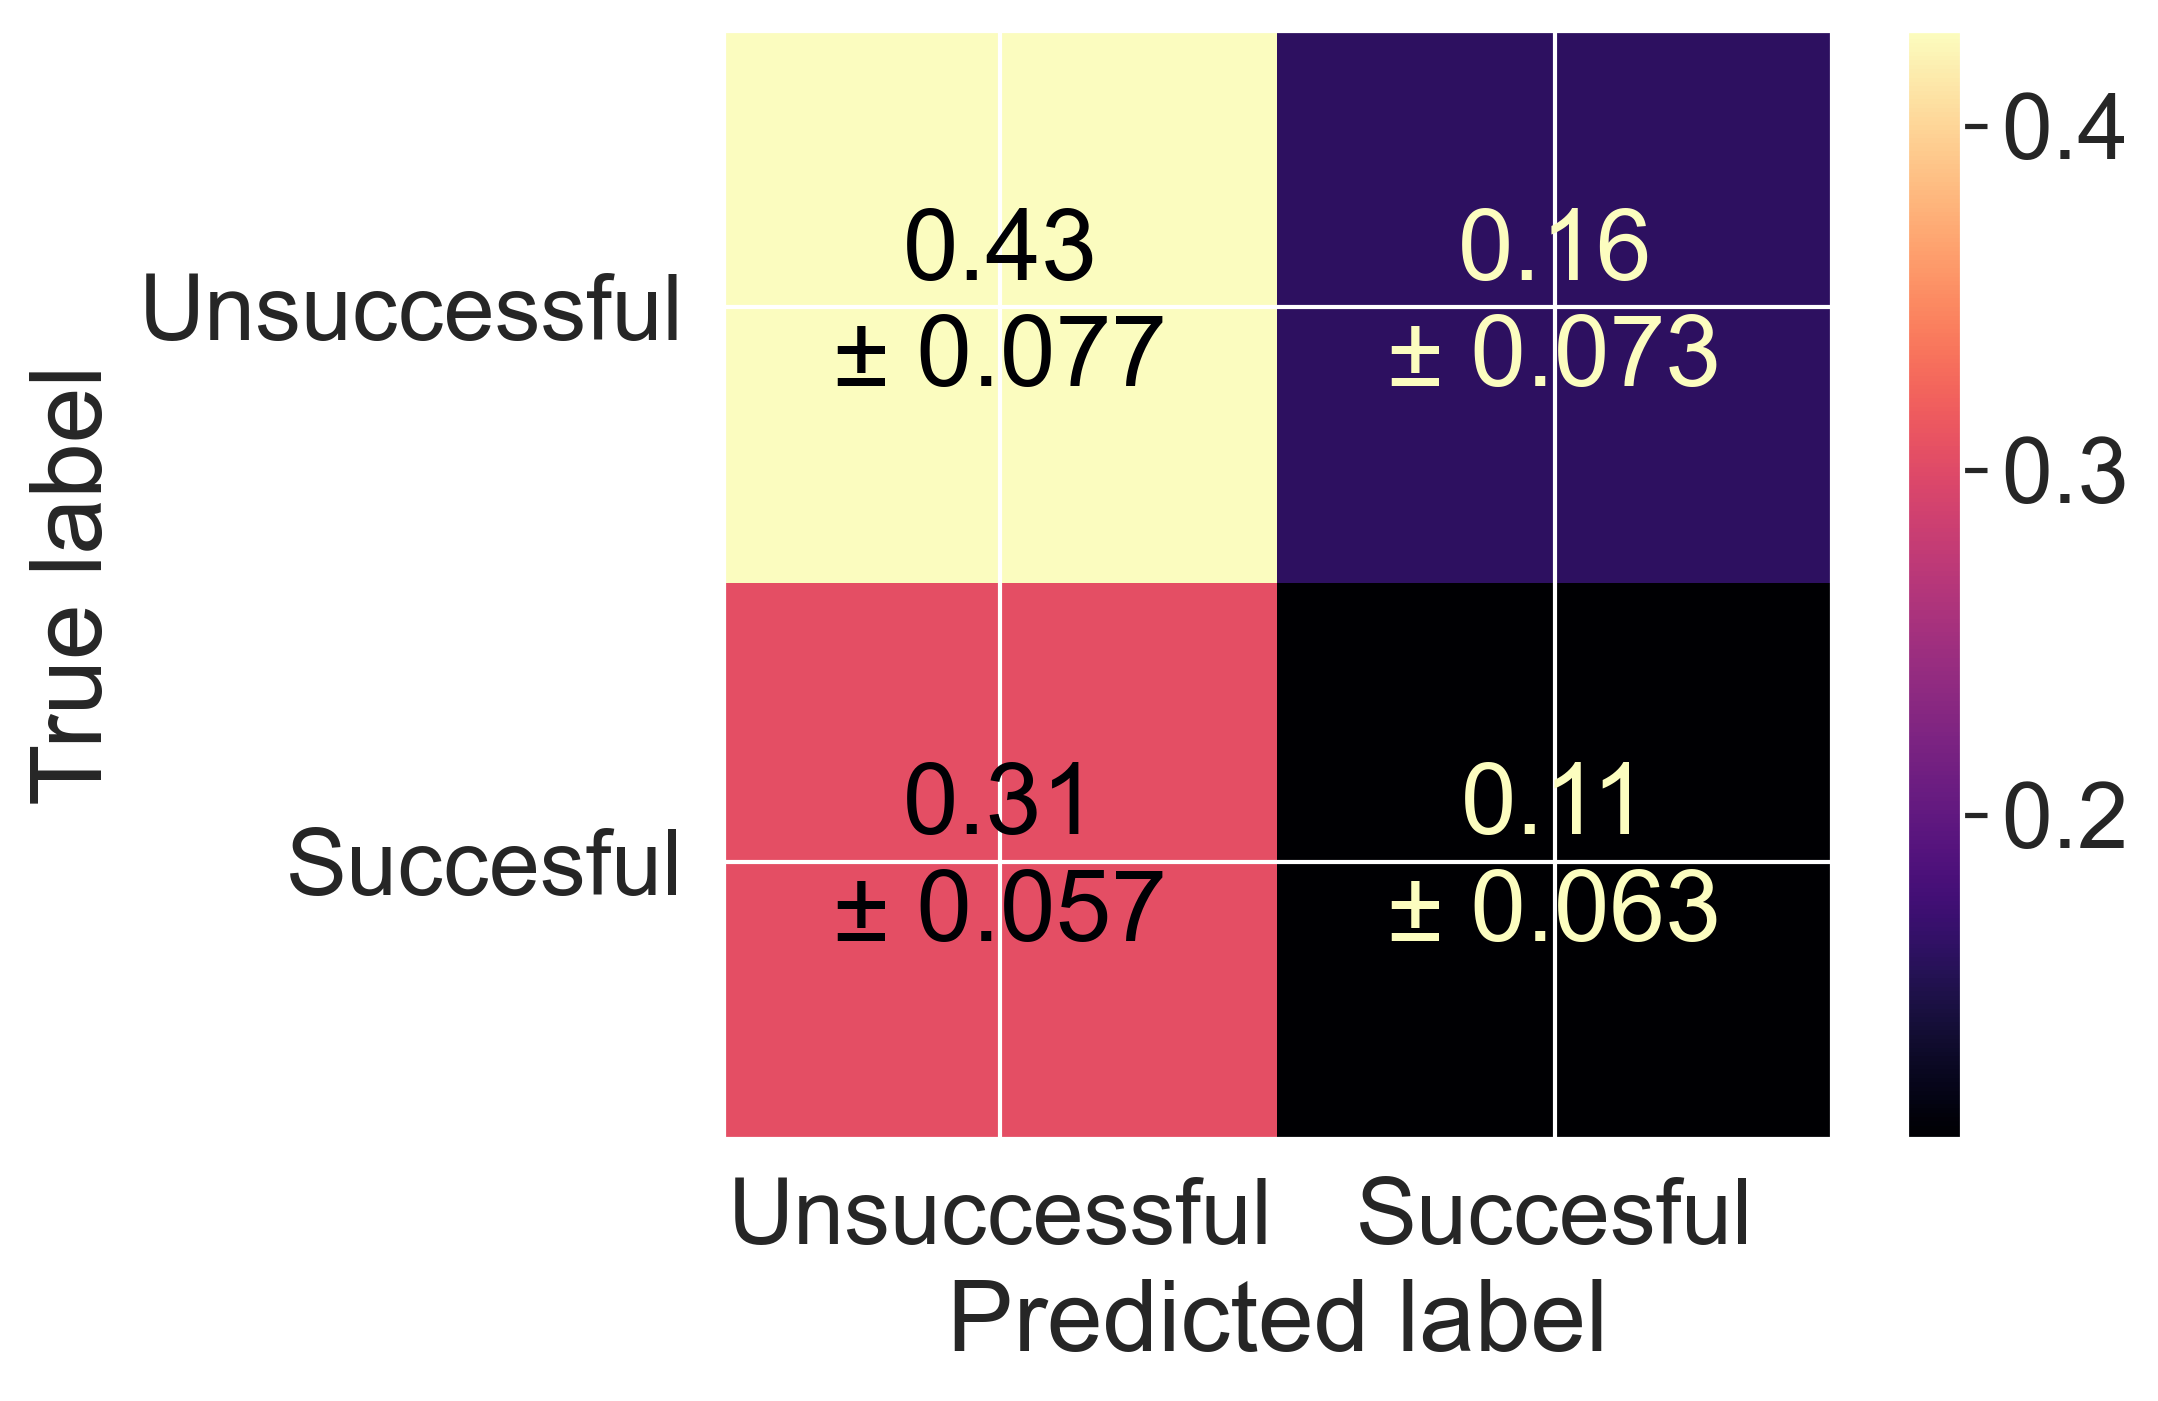

In [38]:
norm_confusion_matrices_random = [matrix/np.sum(matrix) for matrix in all_confusion_matrices_random]
sns.set(font_scale = 2)
disp_random = metrics.ConfusionMatrixDisplay(np.mean(norm_confusion_matrices_random,axis=0),display_labels=["Unsuccessful","Succesful"])
disp_random.plot(cmap="magma")
new_text_mat = np.zeros_like(disp.text_)

for i,(row_text, row_std) in enumerate(zip(disp_random.text_,np.std(norm_confusion_matrices_random,axis=0))):
    for j,(text_object, std_dev) in enumerate(zip(row_text,row_std)):
        new_text = text_object._text +"\n"+u"\u00B1"+" "+ str(np.round(std_dev,decimals=3))
        text_object._text = new_text
        new_text_mat[i,j] = text_object

disp_random.text_ = new_text_mat
disp_random.figure_

plt.savefig(f"{out_revisions}/PLSR Morph early features Random Predictions Confusion Matrix 5 Fold Cross Validation.pdf", format="pdf", bbox_inches="tight")

In [39]:
balanced_accuracies_random = [metrics.balanced_accuracy_score(true,pred) for true, pred in all_test_y_pred_y_random]
balanced_accuracies_random

[0.4724532224532224,
 0.48717948717948717,
 0.5502136752136753,
 0.4578378378378378,
 0.4864864864864865]

In [40]:
roc_auc_random = [metrics.roc_auc_score(true,pred) for (true,_),pred in zip(all_test_y_pred_y_random,all_pred_y_nothresh_random)]
roc_auc_random

[0.503118503118503,
 0.5833333333333334,
 0.5737179487179488,
 0.48864864864864865,
 0.46918918918918917]

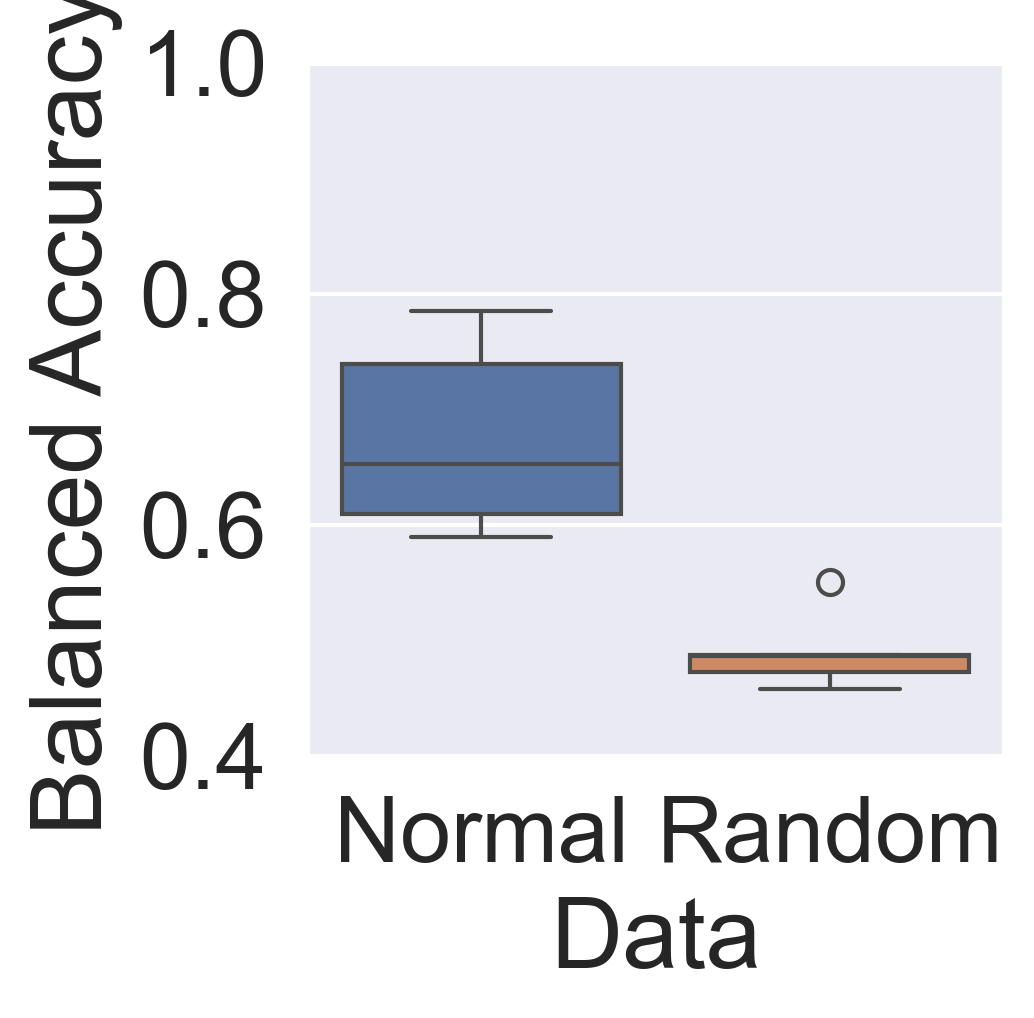

In [41]:
balanced_accuracies_df = pd.DataFrame(
    {
        "Balanced Accuracy":balanced_accuracies_normal+balanced_accuracies_random,
        "Data":["Normal" for i in range(5)] + ["Random" for i in range(5)]
    }
)
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.boxplot(balanced_accuracies_df,x="Data",y="Balanced Accuracy",hue="Data",ax=ax)
ax.set_ylim([0.4,1])
plt.savefig(f"{out_revisions}/PLSR Morph early features PLSR 5fold CV - balanced accuracy.pdf", format="pdf", bbox_inches="tight")

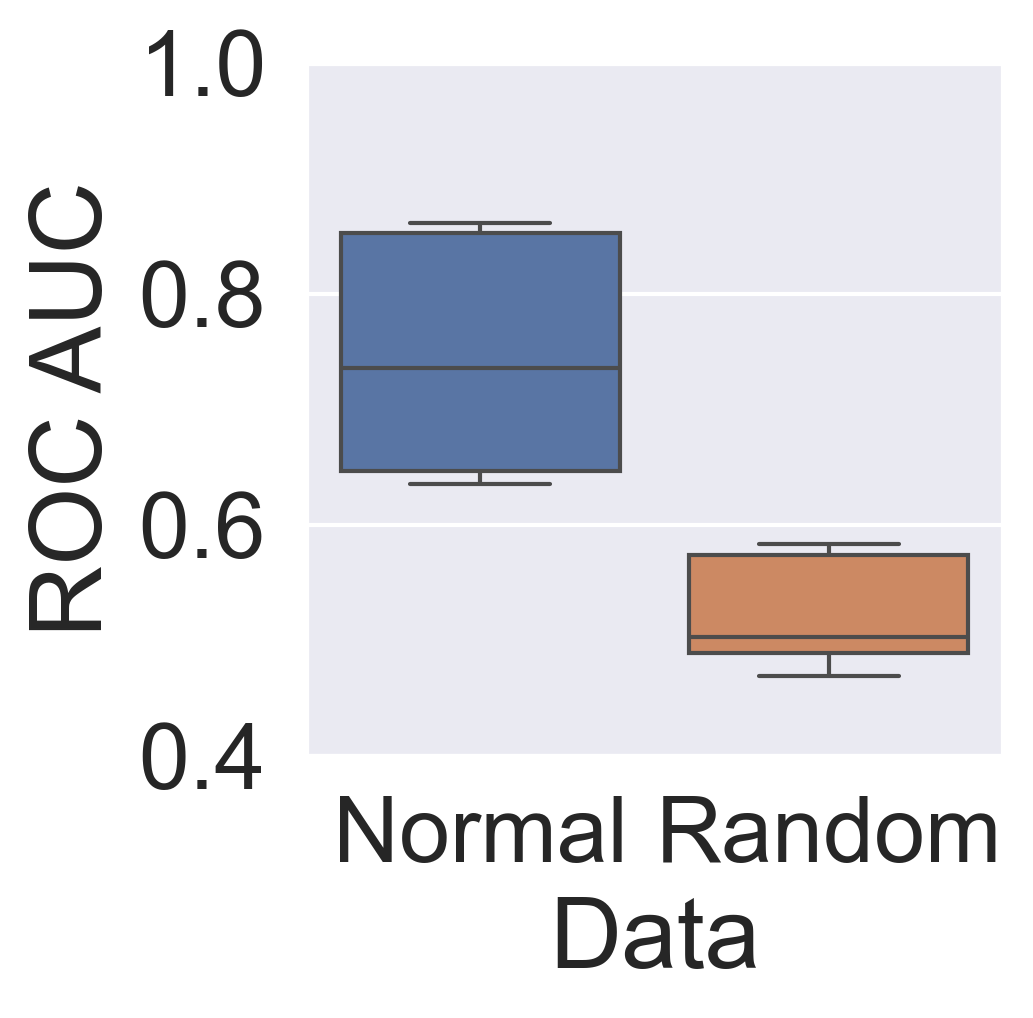

In [42]:
roc_auc_df = pd.DataFrame(
    {
        "ROC AUC":roc_auc_normal+roc_auc_random,
        "Data":["Normal" for i in range(5)] + ["Random" for i in range(5)]
    }
)
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.boxplot(roc_auc_df,x="Data",y="ROC AUC",ax=ax,hue="Data")
ax.set_ylim([0.4,1])
plt.savefig(f"{out_revisions}/PLSR Morph PLSR early features 5fold CV - ROC AUC.pdf", format="pdf", bbox_inches="tight")